In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import types
from sklearn.feature_extraction.text import TfidfVectorizer

from json_data_getter import get_all_json

# Data preparation

## Loading

In [284]:
# use to update database with last articles
from data_downloader import request_data_per_year
request_data_per_year(2017)

requesting for year 2017


In [3]:
# gets all the json files toghether, may take a minute
number_documents, keys, documents = get_all_json()
df = pd.DataFrame.from_dict(documents)

100% (109 of 109) |#######################| Elapsed Time: 0:00:36 Time: 0:00:36


## Cleaning

In [4]:
# keep NaN for float columns, empty strings for string columns
for col in df:
    # get dtype for column
    dt = df[col].dtype
    # check if it is a number
    if dt == int or dt == float:
        pass
    else:
        df[col].fillna("", inplace=True)

# set dates to datetime type
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

In [5]:
# some columns contain list of strings and strings, so we change list of string to sentences
# furthermore, some words are not separated by commas, we do a littre workaround to add commas if they don't exist
def stringlist_to_string(s):
    temp = ''
    if isinstance(s, str):
        if ',' not in s:
            temp = s.replace(' ', ', ')
        else:
            temp = s
    else:
        temp = ', '.join(s)

    # and lowercase because some of theme are uppercases only
    return temp.lower()


for t in [
        'genres', 'thematicCorporations', 'thematicGeographicals',
        'thematicPersons', 'thematicThemes', 'visualCorporations',
        'visualGeographicals', 'visualPersons', 'visualThemes'
]:
    df[t] = df[t].apply(stringlist_to_string)

## distribution in time

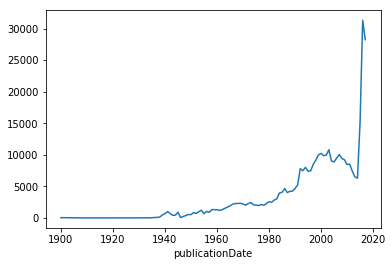

In [6]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()
doc_per_year.plot()
plt.show()

We have a lot more data since the ~90's, and way more of the couple of last years. This mean that our event analysis would make more sense on recent event

## Programs lifespan

In [7]:
def get_program_lifespan(df):
    program_groups = df.groupby(df.program)
    df_lifespan = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_lifespan['lifespan_days'] = (
        df_lifespan['max'] - df_lifespan['min']).astype('timedelta64[D]')
    return df_lifespan

In [8]:
get_program_lifespan(df).sort_values('lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1900-01-01 00:00:00,2017-12-05 00:00:00,20486,43072.0
TJ midi,1900-01-01 19:00:00,2011-12-04 11:45:00,204,40878.0
Marabout de ficelle,1900-01-01 00:00:00,1998-05-20 00:00:00,148,35933.0
Mémoires de la musique,1922-06-05 00:00:00,2004-01-23 00:00:00,2086,29817.0
Archives,1939-11-30 02:00:00,2017-10-03 13:10:37,120,28432.0


The first row is the group of unnamed programs. Some duration seem a bit too long, maybe there are errors in the dates. Let's take TJ midi and check the distribution of transmissions by year.

In [9]:
def plot_program_lifespan(program, df):
    program_groups = df.groupby(df.program)
    group = program_groups.get_group(program)
    date_distribution = group.groupby(
        group.publicationDate.map(lambda x: (x.year))).size()
    plt.bar(date_distribution.index, date_distribution.values)
    plt.show()

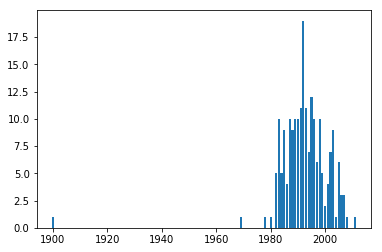

In [10]:
plot_program_lifespan('TJ midi', df)

There are some obvious outliers, let's remove them.

### Date outliers removal

Here we replace the dates with NaT if the year is to far from the mean year of a program.

In [11]:
# remove date outliers
def remove_date_outliers(df):
    CONSTANT_STD = 2
    df_without_date_outliers = df.copy()

    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)

    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])

    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)

    df_without_date_outliers.loc[
        (np.abs(temp_df.publicationDateYear - temp_df['mean']) >
         CONSTANT_STD * temp_df['std']), 'publicationDate'] = pd.NaT

    return df_without_date_outliers

In [12]:
df_without_date_outliers = remove_date_outliers(df)
get_program_lifespan(df_without_date_outliers).sort_values(
    'lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1921-11-23,2017-12-05 00:00:00,20486,35076.0
Documentaire,1952-11-30,2017-12-14 14:10:00,743,23755.0
Cyclisme,1953-11-30,2017-08-19 00:00:00,138,23273.0
Motocyclisme,1954-06-09,2017-12-02 20:45:00,16,23187.0
Souvenirs de vedette,1949-03-31,2009-12-17 00:00:00,4,22176.0


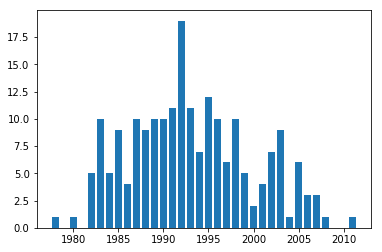

In [13]:
plot_program_lifespan('TJ midi', df_without_date_outliers)

We can see that the distribution seems more natural now.

# Factors for program lifespan

## Themes per period

The goal of this part is to build a tool to get the top occurencies of word in the following categories:
['genres', 'publicationChannelNames', 'thematicCorporations','thematicGeographicals','thematicPersons',
'thematicThemes', 'visualCorporations', 'visualGeographicals', 'visualPersons', 'thematicGeographicals',
'thematicThemes','visualThemes']

We also need to be able to filter by year and by program. This is achieved in the file "word_counter.py". The useful function is "word_counter.get_topn_themes" that takes in argument the starting year and ending year, the type of theme (listed above), a list of programs(TODO), and the number of top occurencies.

In [14]:
import word_counter
from collections import Counter
WC = word_counter.word_counter(df_without_date_outliers)

In [15]:
# this is an example of the top 8 "thematicThemes" of "Temps présent" between 1990 and 2000
WC.get_topn_themes(1990,2000,'thematicThemes', 'Temps présent',n_top=8)

,top1,top2,top3,top4,top5,top6,top7,top8
1990,manifestation politique,cérémonie religieuse,armée,logement,entreprise,scène de rue,conflit armé,écologisme
1991,manifestation politique,enfant (âge),armée,cérémonie religieuse,agriculteur,nationalisme,conflit armé,économie capitaliste
1992,racisme,chômage,enfant (âge),armée,économie,politique,prison,immigration
1993,chômage,économie capitaliste,bébé,adolescence,banane,juifs,nazisme,guerre mondiale (deuxième)
1994,crise économique,adolescence,vieillesse,quartier,banlieue,suicide,homicide,secte
1995,travail des femmes,vieillesse,monarchie,noblesse,vedettariat,bal,presse à sensation,plan de paix
1996,juifs,pauvreté,travail de nuit,travail des femmes,syndicat,condition de travail,années 1990,femme battue
1997,juifs,antisémitisme,pauvreté,quart-monde,armée,banque,guerre mondiale (deuxième),téléphone mobile
1998,retraite (état),vie sociale,amérindiens,nomadisme,vieillesse,refoulement des étrangers,requérant d'asile,fécondation artificielle
1999,ville candidate aux jeux olympiques,olympisme,accident aérien,md11,pilote de ligne,sécurité aérienne,conseiller fédéral,fonction politique


In [16]:
# this is an example of the top 5 "thematicThemes" of all programs between 1935 and 1950
WC.get_topn_themes(1935, 1950, 'thematicThemes',n_top=5)

,top1,top2,top3,top4,top5
1935,paix,conflit armé,relations internationales,vie politique,économie
1936,cirque,roi,guerre mondiale (première),politique,vie politique
1937,relations internationales,cirque,radio,guerre mondiale (première),politique
1938,guerre mondiale (deuxième),radio,mobilisation générale (1939-1945),armée,histoire
1939,guerre mondiale (deuxième),littérature,mobilisation générale (1939-1945),armée,patriotisme
1940,guerre mondiale (deuxième),patriotisme,littérature,commémoration,écrivain
1941,guerre mondiale (deuxième),patriotisme,art dramatique,rationnement,commémoration
1942,guerre mondiale (deuxième),recette culinaire,rationnement,armée,art dramatique
1943,guerre mondiale (deuxième),armée,rationnement,recette culinaire,économie de guerre
1944,guerre mondiale (deuxième),résistance (1939-1945),paix,reddition militaire,littérature


### Generate JSON file for the word cloud visualization

In [210]:
def normalize_counter(c, max_words):
    temp_c = dict(c.most_common(max_words))
    if len(temp_c) < 1:
        return temp_c
    min_val = min(list(temp_c.values()))
    max_val = max(list(temp_c.values()))
    dividor = (max_val-min_val) if (max_val-min_val) is not 0 else 1
    for key in temp_c:
        temp_c[key] = (temp_c[key]-min_val)*100/dividor
    return temp_c

In [222]:
counters_program_period = df[[
    'genres', 'thematicGeographicals',
    'thematicPersons', 'thematicThemes',
    #'visualCorporations', 'visualGeographicals', 'visualPersons', 'visualThemes', 'thematicCorporations'
]].groupby(df.publicationDateYear).agg(lambda x: ', '.join(x))

In [223]:
for col in counters_program_period:
    vectorizer = TfidfVectorizer(
        stop_words=['et', 'de', 'à', 'en'], ngram_range=(1, 2))
    vect_col = vectorizer.fit_transform(counters_program_period[col])
    words = vectorizer.get_feature_names()
    X = vect_col.toarray()
    result = [
        Counter({
            word: occurence
            for occurence, word in zip(X_row, words) if occurence > 0
        }) for X_row in X
    ]
    counters_program_period[col] = result

In [224]:
counters_program_period = counters_program_period.applymap(lambda x : normalize_counter(x, 500))

C:\Users\Leonovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [214]:
counters_program_period.columns=['Genra', 'Locations', 'Persons', 'Topics']
counters_program_period.to_json('themes_by_year_accent.json', force_ascii=True)

### Why are there so many "cloches" around 1958

In [226]:
cloche = df_without_date_outliers[(df_without_date_outliers.publicationDate.map(lambda x: x.year) == 1958) &
                         (df_without_date_outliers.thematicThemes.str.contains("cloche"))]

In [227]:
cloche[['title', 'contributors', 'mediaType', 'publicationDate']].head()

,title,contributors,mediaType,publicationDate
12675,"Carillon de Chantemerle, temple de Pully-La Ro...",,audio,1958-12-24
12710,Cloches du temple (église protestante renovée)...,,audio,1958-12-14
12804,Cloches du temple protestant de Vulliens (VD),,audio,1958-11-25
12840,Cloches de Châtel-Saint-Denis (FR),,audio,1958-03-29
12882,Cloches de Zermatt (VS),,audio,1958-03-17


## Lifespan category

Now that we have the lifespan of each program, let's see the histogram.

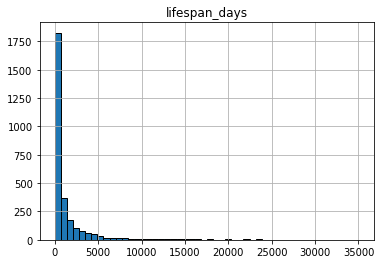

In [228]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

The distribution is heavy tailed, lot of programs are really short. Next step is to see how the type of program and the themes are correlated with the lifespan. To do this, we decide to class program in 5 categories of lifespan, each category having the same number of programs.

In [229]:
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 5, labels=['very short', 'short', 'medium', 'long', 'very long']))

### TODO, look at the different themes for each bucket

In [272]:
df_by_lifespan = pd.merge(
    df_without_date_outliers.loc[df_without_date_outliers.program != ""],
    lifespan,
    left_on='program',
    right_index=True,
    how='left').groupby('lifespan_class')

In [273]:
counters_program_lifespan = df_by_lifespan[[
    'genres', 'thematicGeographicals', 'thematicPersons', 'thematicThemes'
]].agg(lambda x: ', '.join(x))

In [274]:
for col in counters_program_lifespan:
    vectorizer = TfidfVectorizer(
        stop_words=['et', 'de', 'à', 'en'], ngram_range=(1, 2))
    vect_col = vectorizer.fit_transform(counters_program_lifespan[col])
    words = vectorizer.get_feature_names()
    X = vect_col.toarray()
    result = [
        Counter({
            word: occurence
            for occurence, word in zip(X_row, words) if occurence > 0
        }) for X_row in X
    ]
    counters_program_lifespan[col] = result

In [275]:
counters_program_lifespan = counters_program_lifespan.applymap(lambda x : normalize_counter(x, 10000))

In [283]:
Counter(counters_program_lifespan.loc['very long'].genres).most_common()

[('interview', 100.00000000000001),
 ('interview interview', 52.085632604215135),
 ('flashes', 26.108636393856788),
 ('téléjournal', 26.108636393856788),
 ('téléjournal flashes', 26.108636393856788),
 ('commentaire', 17.554683864104781),
 ('emissions', 15.241007911707996),
 ('flashes téléjournal', 14.831695449843098),
 ('actualités', 13.638483912963697),
 ('adolescents', 13.003124792234559),
 ('emissions pour', 13.003124792234559),
 ('enfants', 13.003124792234559),
 ('enfants adolescents', 13.003124792234559),
 ('pour', 13.003124792234559),
 ('pour enfants', 13.003124792234559),
 ('actualités régionales', 12.993909964043384),
 ('régionales', 12.993909964043384),
 ('interview commentaire', 9.4475101389535272),
 ('commentaire interview', 9.4023003789641653),
 ('magazines', 8.9010039226115278),
 ('magazines sportifs', 8.9010039226115278),
 ('résultats', 8.9010039226115278),
 ('résultats magazines', 8.9010039226115278),
 ('sportifs', 8.9010039226115278),
 ('autres', 8.3398710192141472),
 (

# Gender

Over the last two decades, gender eqaulity has grown as one of the main concerns of developped countries. There are even metrics (as Gender Inequality Index) and annual reports on that subject. 
It's a known fact that Switzerland, unlike Scandinavian counrties, is not the best model in that specific field.<br>

In that part, we would like to analyse, through the RTS dataset, the evolution of gender representation on RTS programs over the years. Namely, we would like to answer the following questions: <br>
How has the distribution of genders for anchors and presenters evolved over the course of the years?<br> Was there a gender bias? If yes, how has it changed? 
What about gender evolution per role, i.e. director, presentor, interviewers, etc. ?

In [243]:
import requests,json
import pandas as pd
import numpy as np
import copy
import csv
import matplotlib.pyplot as plt
from json_data_getter import get_all_json
import plotly

#plotly.tools.set_credentials_file(username='sfa', api_key='dYSNYCTetzyhxfSKo0Cp')
plotly.tools.set_credentials_file(username='Jvj', api_key='2olbZsRiUzIhtwxWsPQy')


import warnings
warnings.filterwarnings("ignore")

<b>Utilitary functions</b><br>
The python script getGenders.py is executed separetly to this notebook to create a csv file in dictionary format with firstnames and their corresponding genders. 

In [3]:
def getgenderDict():
    """
    We stored (see getGenders.py) all the firstnames in RTS dataset in a csv file.
    Here we load it into a dictionary.
    """
    with open('../dataset/gender.csv', mode='r') as infile:
        reader = csv.reader(infile)
        genderdict = dict((rows[0], rows[1]) for rows in reader)
    return genderdict

def getListRoles():
    """
    The 'contributors' columns contains many human roles, e.g. Interviewé,Directeur, etc.
    Here we return the list of all roles.
    """
    listRoles =  [list(role.keys()) for role in [roles for roles in df_Roles.contributors.values] if isinstance(role, dict)]    
    listRoles = set([item.replace("/","").replace(" ","").replace("'",'') for sublist in listRoles for item in sublist])
    return sorted(list(listRoles))

def removeYearsFromRolesDict(roles):
    """
    The 'contributors' columns contains many human roles, e.g. Interviewé,Directeur, etc.
    Here we return the list of all roles.
    """
    for role,dico in roles.items():
        if dico:
            for name in list(dico.keys()):
                firstnameLastname = name.split('-')[0]+'-'+name.split('-')[1]
                #print(name.split('-')[0:3])
                dico[firstnameLastname] = dico.pop(name)
    return roles

Now let's explore the names and genders in more details<br>
As we wish to analyse firstname over the years, we remove all elements that don't contain date information or name of the contributors.<br>
For a better visualisation, we remove all columns that are not necessary  for this part.<br>
We can see below what a contributor field looks like. It's a dictionary (different roles) of dictionary (person related information).


In [28]:
df_Roles = df_without_date_outliers.copy()
df_Roles = df_Roles[df_Roles.contributors.notnull()]
df_Roles.drop(['alternativeExcerpt','alternativeTitle','excerpt','thematicThemes','title',
               'articleURL','backgrounds',  'durationSec', 'id',
                'imageURL','isOnline','mediaURL','source','thematicPersons','visualGeographicals',
                'visualPersons','visualCorporations','variantIds','visualThemes','mediaType',
                'publicationChannelNames','publicationDate','thematicGeographicals',
                'thematicCorporations','program','genres'], axis=1, inplace=True)
df_Roles = df_Roles[(df_Roles.publicationDateYear.notnull()) & (df_Roles.contributors.notnull()) 
                   & (df_Roles.contributors != '')]
pd.options.display.max_colwidth = 220
df_Roles.head()

,contributors,publicationDateYear
7,"{'Auteur d'une déclaration': [{'name': 'François-Joseph Ier', 'role': 'empereur d'Autriche et roi de Hongrie', 'type': 'Participant'}]}",1900
9,"{'Interviewé/e': [{'name': 'François-Joseph Ier', 'role': 'Empereur d'Autriche et roi de Hongrie', 'type': 'Participant'}]}",1900
12,"{'Récitant/e': [{'name': 'Carcélès, Isabelle', 'role': 'collaboratrice RSR', 'type': 'Participant'}], 'Auteur du texte': [{'name': 'Carcélès, Isabelle', 'role': 'collaboratrice RSR', 'type': 'Auteur'}]}",1900
14,"{'Choeur': [{'name': 'Marmousets, Fribourg', 'role': 'choeur d'enfants', 'type': 'Participant'}], 'Direction': [{'name': 'Kaelin, Pierre', 'type': 'Participant'}]}",1900
15,"{'Auteur d'une déclaration': [{'name': 'Shaw, Bernard', 'role': 'critique musical, dramaturge, essayiste, auteur de pièces de théâtre et scénariste irlandais', 'type': 'Participant'}]}",1900


Let's create the gender dictionary from our csv file. This will allows us to know the gender of a person based on his firstname.<br>
We also create a dictionary based on all possible roles. We will then use it, to observe the evolution of genders per role.<br> The keys will represents the roles and the values (filled later) will be themeselves a dictionary of all people who worked in that role.

In [30]:
gender_dict = getgenderDict() 
listRoles   = getListRoles()
RolesDict = dict(zip(listRoles,[dict() for el in listRoles]))

In [107]:
cmtTotal  = len(gender_dict) 
cmtFemale = len([sex  for sex in gender_dict.values() if sex == 'female'])
print('We found ', cmtFemale, ' female names vs ', cmtTotal - cmtFemale, 'male names in RTS dataset')
print('Joseph Jacques is a :',gender_dict.get(' Joseph Jacques')) # Just as an example

We found  2365  female names vs  4356 male names in RTS dataset
Joseph Jacques is a : male


Here, we fill the values of the RolesDict mentionned above. For each year and for each role, we add the the (firstnames:gender) of the people who worked there in the correponding RolesDict value.

In [235]:
nbmale_dict,nbfemale_dict,nameOccurenced,presentateurs = dict(),dict(),dict(),dict()
uknownNames = list()

for year in set(df_Roles.publicationDateYear.values):
    print(year,end=" ;")
    yearContributors = df_Roles.contributors[df_Roles.publicationDateYear == year]
    for contributors in yearContributors:
        if contributors == '':
            continue
        for key, value in contributors.items():
            role      = key
            role = role.replace("/","")
            role = role.replace(" ","")
            role = role.replace("'","")
            try:
                firstname = value[0]['name'].split(',')[1]
                lastname  = value[0]['name'].split(',')[0]
                gender    = gender_dict.get(firstname)
                if gender is None:
                    uknownNames.append(firstname)
                keyvalue  = firstname+'-'+lastname+'-'+str(year)
                (RolesDict.get(role))[keyvalue]=gender
                old       = any([keyvalue in key for key in nameOccurenced.keys()])

                nameOccurenced[firstname+'-'+lastname] = nameOccurenced.get(keyvalue, 0) + 1
                if not old and gender == 'male':
                    nbmale_dict[year] = nbmale_dict.get(year, 0) + 1
                elif not old and gender == 'female':
                    nbfemale_dict[year] = nbfemale_dict.get(year, 0) + 1
                else:
                    pass 
                if year not in nbfemale_dict:
                    nbfemale_dict[year] = 0
            except:
                 pass # if name value is weird, we ignore it. Example: name: François-Joseph Ier

1900 ;1908 ;1911 ;1912 ;1913 ;1914 ;1915 ;1916 ;1917 ;1918 ;1919 ;1920 ;1921 ;1922 ;1923 ;1924 ;1925 ;1927 ;1928 ;1929 ;1930 ;1931 ;1932 ;1933 ;1934 ;1935 ;1936 ;1937 ;1938 ;1939 ;1940 ;1941 ;1942 ;1943 ;1944 ;1945 ;1946 ;1949 ;1950 ;1951 ;1952 ;1953 ;1954 ;1955 ;1956 ;1957 ;1958 ;1959 ;1960 ;1961 ;1962 ;1963 ;1964 ;1965 ;1966 ;1967 ;1968 ;1969 ;1970 ;1971 ;1972 ;1973 ;1974 ;1975 ;1976 ;1977 ;1978 ;1979 ;1980 ;1981 ;1982 ;1983 ;1984 ;1985 ;1986 ;1987 ;1988 ;1989 ;1990 ;1991 ;1992 ;1993 ;1994 ;1995 ;1996 ;1997 ;1998 ;1999 ;2000 ;2001 ;2002 ;2003 ;2004 ;2005 ;2006 ;2007 ;2008 ;2009 ;2010 ;2011 ;2012 ;2013 ;2014 ;2015 ;2016 ;2017 ;

In [236]:
print('On Average, each year, there are  ',str(round(np.mean(list(nbmale_dict.values())), 2)), ' males vs' , str(round(np.mean(list(nbfemale_dict.values())), 2)), ' females')

On Average, each year, there are   5545.6  males vs 2118.45  females


RolesDictNoYears contains the list of all people (their (firstname, lastname) and gender in dictionary format) who have worked for a specific role, for every role (in dictionary format). 

In [237]:
RolesDictNoYears = copy.deepcopy(RolesDict)
RolesDictNoYears = removeYearsFromRolesDict(RolesDictNoYears)
sorted([(len(v),k) for k, v in RolesDictNoYears.items() if v],reverse=True)[0:5]



[(37916, 'Interviewée'),
 (2794, 'Auteurdutexte'),
 (2358, 'Intervieweureuse'),
 (2080, 'Auteurdunedéclaration'),
 (2027, 'Commentateurtrice')]

Now, let's see the overall (without considering dates) distribution of genders per role.

In [238]:
rolesGenderRatio = dict()
rolesGenderRatiodf = pd.DataFrame(index= listRoles,columns=['nbOfmen','nbOfwomen','ratio'])
for role,dico in RolesDictNoYears.items():
    if dico:
        totalNumerPerRole= sum( x == 'male' or x== 'female' for x in dico.values()) # ignoring None
        nbOfmen          = sum( y == 'male' for y in dico.values())
        nbOfwomen        = sum( y == 'female' for y in dico.values())
        ratio            = 0
        if totalNumerPerRole > 0 :
            ratio = nbOfwomen/totalNumerPerRole
            rolesGenderRatio[role] = ratio
        else:
            rolesGenderRatio[role] = 0
        rolesGenderRatiodf.loc[role]=[nbOfmen,nbOfwomen,ratio]   

In [253]:
favoriteRoles = ['Réalisateur','Présentateurtrice','Journaliste','Divers',
                 'Producteur','Interviewée','Présentateurmétéo','Intervieweureuse','Commentateurtrice']
englishNames  = ['Director', 'Presenter', 'Journalist', 'Various', 'Producer','Interviewed',
                 'Weather Presenter', 'Interviewer','Commentator']
rolesGenderRatioSelected = rolesGenderRatiodf.loc[favoriteRoles]
subDico = [rolesGenderRatioSelected.loc[k].ratio for k in favoriteRoles]

data = [go.Bar(
            x=favoriteRoles,
            y=subDico
    )]

layout = go.Layout(
    title='Pourcentage of number of women per role', xaxis = dict(range=[englishNames]),yaxis  = dict(range=[0,0.5])
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='genderDistributionNoData')

The chart above shows the gender distribution per role, without considering the date.  
We can observe female representation is higher in the roles that have a direct contact with the audience as Weather Presenter and  Interviewer.

In [240]:
nbmale_dict_role    = dict(zip(listRoles,[dict() for el in listRoles])) 
nbfemale_dict_role  = dict(zip(listRoles,[dict() for el in listRoles]))
for role,v in RolesDict.items():
    for person, gender in v.items():
        year = person.split('-')[-1]
        if gender == 'male': 
             (nbmale_dict_role.get(role))[year] = (nbmale_dict_role.get(role)).get(year, 0) + 1
        elif gender == 'female':
            (nbfemale_dict_role.get(role))[year] = (nbfemale_dict_role.get(role)).get(year, 0) + 1
        else:
            pass 
        if year not in (nbfemale_dict_role.get(role)):
            (nbfemale_dict_role.get(role))[year] = 0
        if year not in (nbmale_dict_role.get(role)):
            (nbmale_dict_role.get(role))[year] = 0


Let's now do a simple check to see if we have fileld correctly our dicts.<br>
To do this, we choose a role that appears only a single time in the whole Dataset: TEX<br>
We don't what TEX represents but it's usefull for our demonstration here :)
<br>Note that you can choose any other role. 

In [272]:
print('Number of males for TEX role', nbmale_dict_role.get('TEX'),',number of females for TEX role',nbfemale_dict_role.get('TEX'))
print('All persons who worked in TEX role', RolesDict.get('TEX'))
pd.options.display.max_colwidth = 820
df_Roles[(df_Roles['contributors'].apply(str).str.contains('TEX\''))]

Number of males for TEX role {'1987': 1} ,number of females for TEX role {'1987': 0}
All persons who worked in TEX role {' Joseph-Badet-1987': 'male'}


,contributors,publicationDateYear
80423,"{'Présentateur/trice': [{'name': 'Terrapon, Michel', 'type': 'Participant'}], 'Auteur du texte': [{'name': 'Bibois ', 'type': 'Auteur'}], 'Producteur/trice Radio': [{'name': 'Terrapon, Michel', 'role': 'collaborateur/trice RSR', 'type': 'Producteur'}], 'vide': [{'name': 'Terrapon, Michel', 'type': 'Auteur'}], 'Récitant/e': [{'name': 'Ferry, Marcel', 'type': 'Participant'}, {'name': 'Martinetto, Elena', 'type': 'Participant'}], 'Commentateur/trice': [{'name': 'Bossard, Maurice', 'type': 'Participant'}], 'REC': [{'name': 'Badet, Joseph', 'role': 'Récitant/e', 'type': 'Participant'}], 'TEX': [{'name': 'Badet, Joseph', 'role': 'Auteur du texte', 'type': 'Auteur'}]}",1987


In [170]:
print(len(uknownNames) ,'firstnames were not found on our gender dictionary. Here are few ones: \n')

from collections import Counter
print(Counter(uknownNames).most_common()[0:5])


2199 firstnames were not found on our gender dictionary. Here are few ones: 

[(' Claude (journaliste)', 510), (' Marcel W.', 157), (' Roger (homme de radio)', 121), (' Jean)', 72), (' Constant]', 51)]


Now let's plot the results. Namely, let's see the evolution, over the years, of gender distribution for our favourite roles.  

Divers


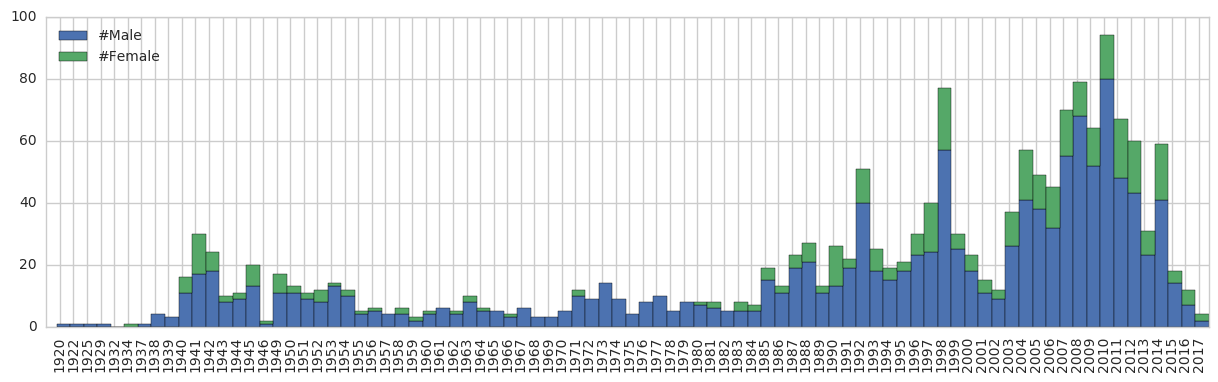

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Jvj/0 or inside your plot.ly account where it is named 'genderEvoltionDivers'
Présentateurmétéo


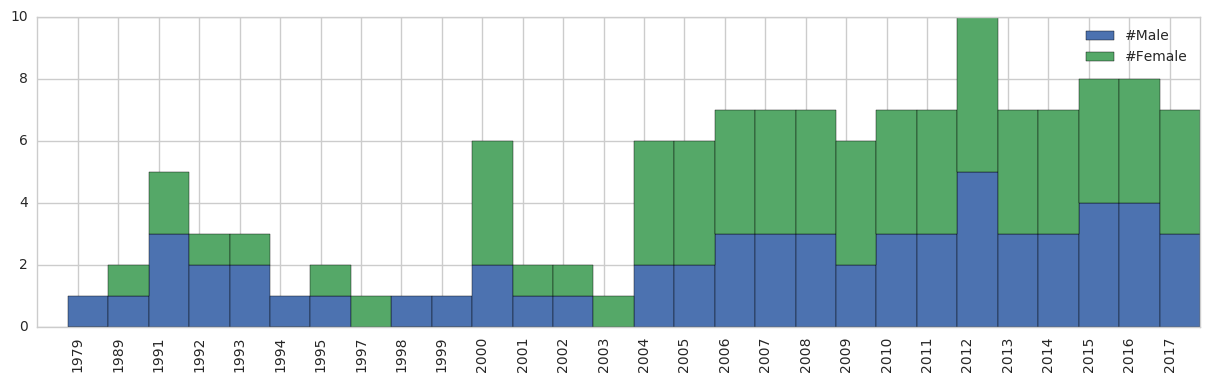

Intervieweureuse


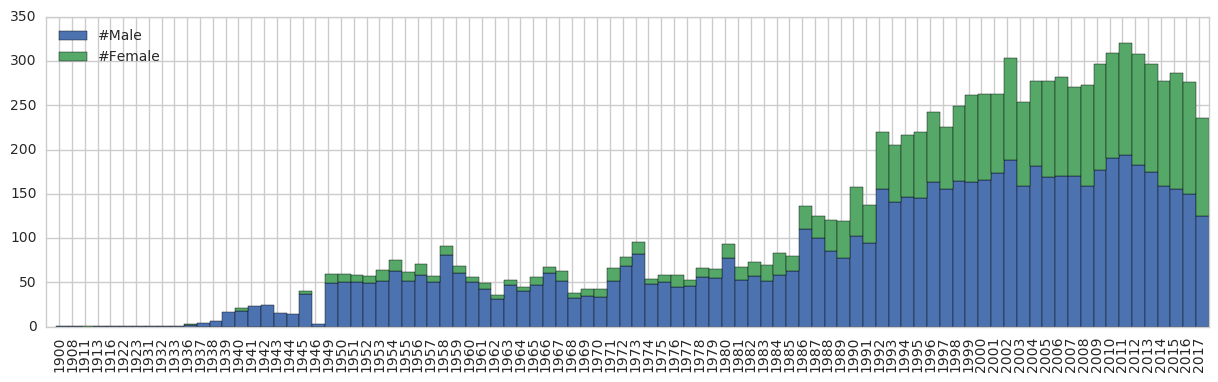

Réalisateur


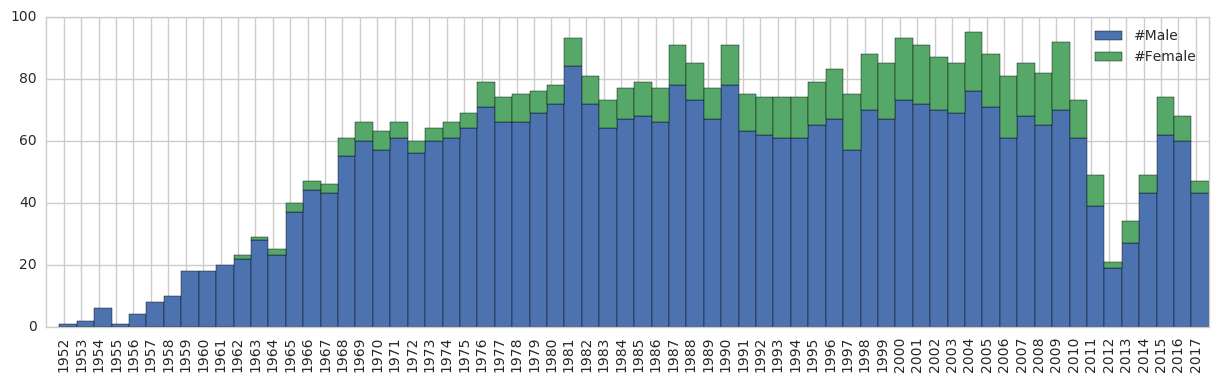

Interviewée


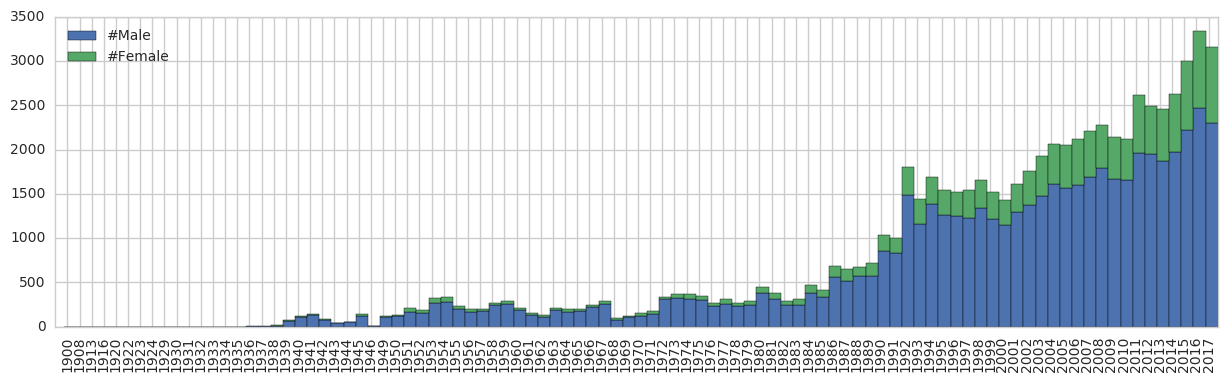

Producteur


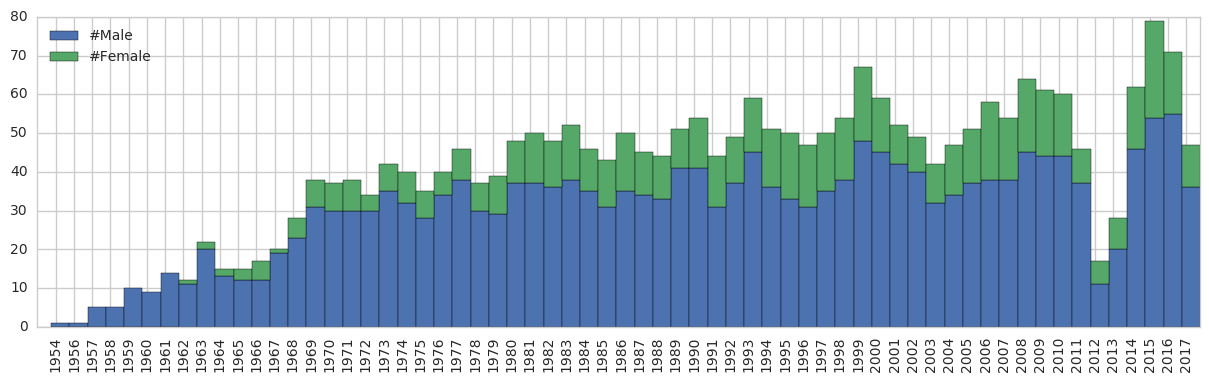

Journaliste


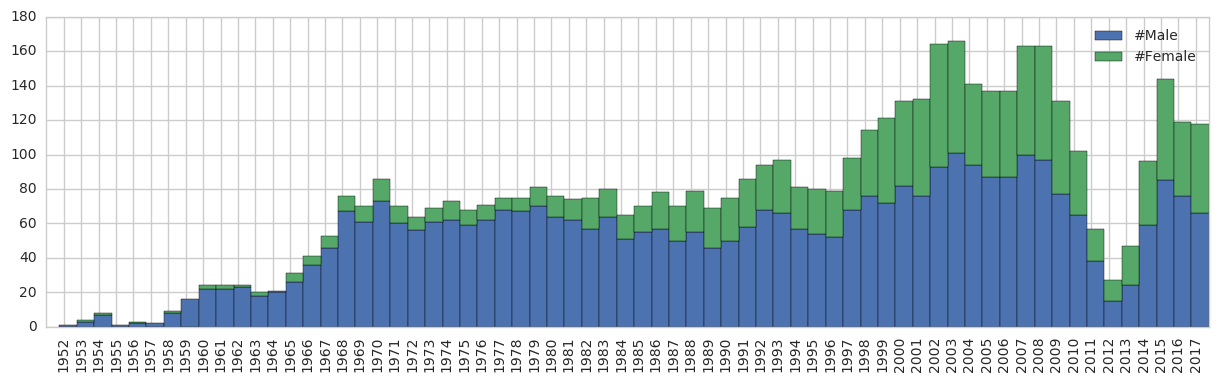

Direction


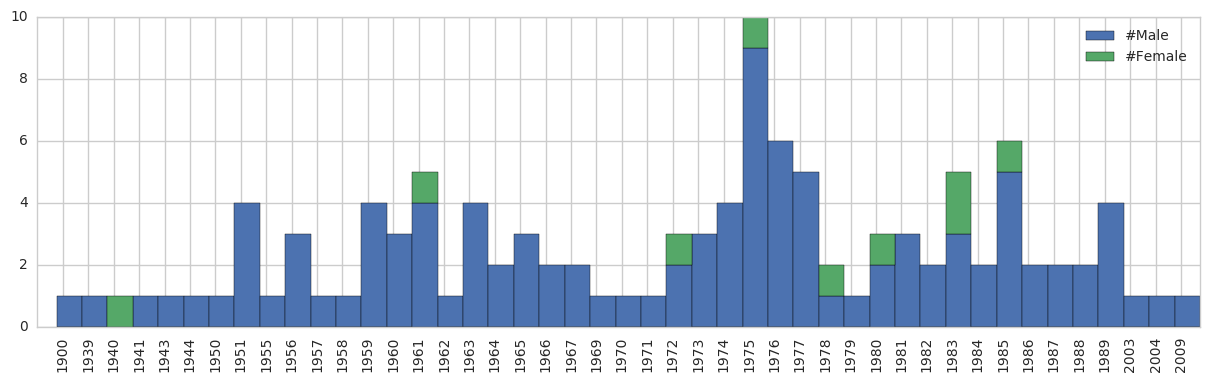

Présentateurtrice


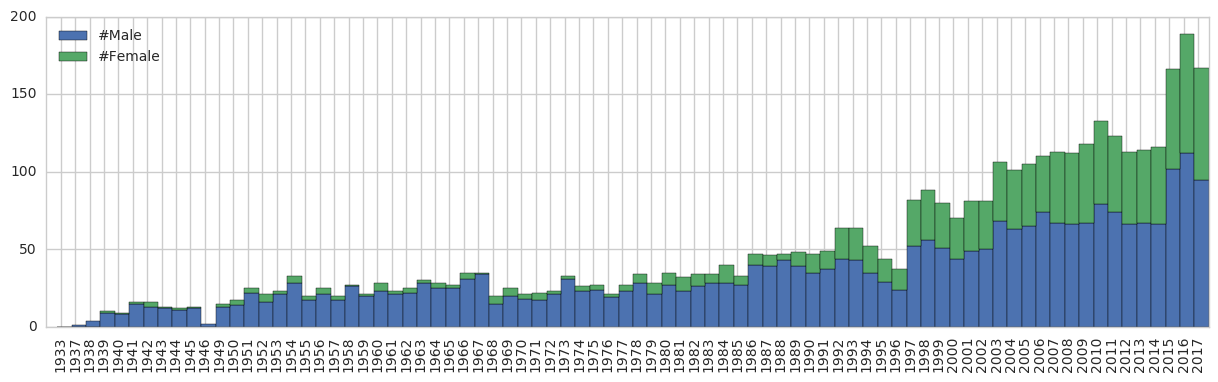

Commentateurtrice


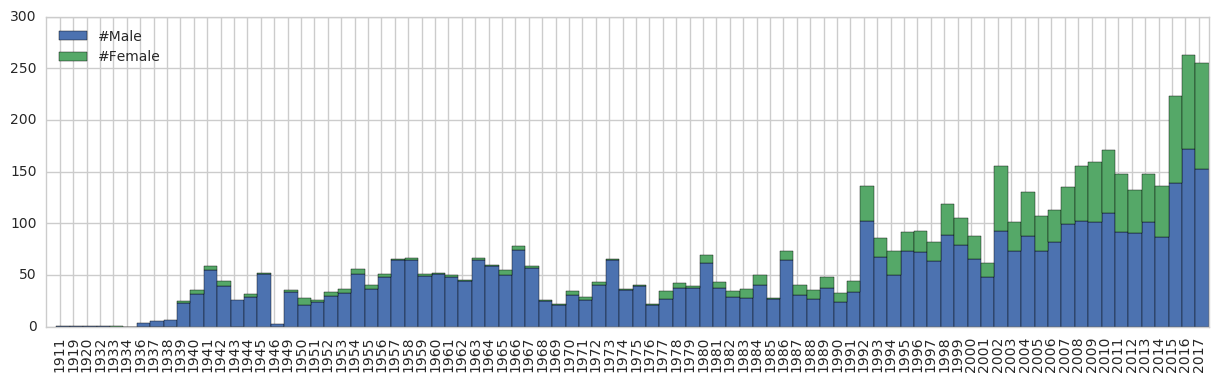

In [244]:
favoriteRoles = ['Réalisateur','Présentateurtrice','Journaliste','Divers','Direction',
                 'Producteur','Interviewée','Présentateurmétéo','Intervieweureuse','Commentateurtrice']
for (role, vm),(rolef,vf) in zip(nbmale_dict_role.items(),nbfemale_dict_role.items()):
    if role in favoriteRoles : 
        print(role)

        dfGenderresults = pd.DataFrame.from_dict(vm, orient='index')


        genderEvolutionRole = pd.DataFrame.from_dict([vm, vf]).T
        if not genderEvolutionRole.empty:
            genderEvolutionRole.columns = ['#Male', '#Female']
            ax = genderEvolutionRole.plot.bar( stacked=True, align='center',figsize=(15,4));
            for container in ax.containers:
                plt.setp(container, width=1)
            x0, x1 = ax.get_xlim()
            ax.set_xlim(x0 -0.5, x1 + 0.25)

            plt.show()


            trace1 = go.Bar(x=list(vm.keys()),y=list(vm.values()),name='Male')
            trace2 = go.Bar(x=list(vm.keys()),y=list(vf.values()),name='Female')
            data = [trace1, trace2]
            layout = go.Layout(barmode='stack')
            fig = go.Figure(data=data, layout=layout)
            py.iplot(fig, filename='genderEvoltion'+str(role))

# Evolution of RTS coverage of social phenomena

In this part, we are intressted in the evolution over time, as covered by RTS, of some of the main social phenomenas we have gone through in the 21st century. Namely, we choose to see the evolution of the following subjects:
<ul>
  <li>Women's voting rights</li>
  <li>Feminisme</li>
  <li>Terrorisme</li>
  <li>Familly</li>
  <li>Mariage</li>
  <li>Homosexuality</li>
</ul>

In [139]:
import re
import seaborn as sns
from collections import Counter

The main feature of interest for this part is 'thematicThemes'. Additionnaly, we will use some other features which, when available,  give additional information about the theme. These features are : alternativeExcerpt , 'alternativeTitle', 'excerpt' and 'title'.

In [134]:
allThemes = list(set([item.lower() for sublist in df_without_date_outliers.thematicThemes.tolist() 
                      for item in sublist]))

df_themes = df_without_date_outliers.copy()
df_themes = df_themes[(df_themes.thematicThemes.notnull()) & (df_themes.thematicThemes != '')] 
df_themes.drop(['articleURL','backgrounds', 'contributors',  'durationSec', 'id',
                'imageURL','isOnline','mediaURL','source','thematicPersons','visualGeographicals',
                'visualPersons','visualCorporations','variantIds','visualThemes','mediaType',
                'publicationChannelNames','publicationDate','thematicGeographicals',
                'thematicCorporations','program','genres'], axis=1, inplace=True)
df_themes[(df_themes['alternativeExcerpt'].notnull())  & (df_themes['alternativeExcerpt'] != '')].head()

,alternativeExcerpt,alternativeTitle,excerpt,thematicThemes,title,publicationDateYear
214,[Edvard Benes fait un discours inaugural à la session de la SDN.],"[Discours à la SDN / SIR_1935-09-09_emission-sans-nom_6F524344-E2F3-4189-AE6B-9AD6134E25B7 / Discours d'Edvard Benes, président élu (extrait)]","(0- 4.42) Discours d'Edvard Benes, président élu. Il remercie le discours de son prédécesseur qui rend hommage à son pays, la Tchécoslovaquie. Dès le début de la SDN, la Tchécoslovaquie a fait depuis 16 ans la politi...","[désarmement, paix, politique internationale, organisation internationale, réunion internationale, économie, politique agricole, politique d'armement]","Discours d'Edvard Benes, président élu (extrait)",1935
290,[Premier coup de pioche pour la Maison de la Radio à Genève.],"[SIR_1938-01-01_emission-sans-nom_06897ED5-C2C2-4470-8813-BD90B9C23A3F / Premier coup de pioche à la Maison de la Radio à Genève : Interview de Jean Camoletti, architecte, Emission sans nom]",,"[architecture, bâtiment, radio]","Premier coup de pioche à la Maison de la Radio à Genève : Interview de Jean Camoletti, architecte",1938
346,"[Le Gendre de Monsieur Poirier, par la Comédie de Genève.]","[SIR_1937-03-25_emission-sans-nom_F82E16A5-D98B-46F2-B8B7-BF2DE5EB009B / Le Gendre de Monsieur Poirier. Pièce d'Emile Augier et Jules Sandeau, interprétée par la troupe de la Comédie de Genève (extraits), Emission sa...","La pièce de théâtre a été représentée le 8 avril 1854 pour la première fois à Paris. Le gendre de Monsieur Poirier est un aristocrate, amateur de frivolités. Il décide de changer de vie pour se consacrer à son épouse...","[bourgeoisie, aristocratie]","Le Gendre de Monsieur Poirier. Pièce d'Emile Augier et Jules Sandeau, interprétée par la troupe de la Comédie de Genève (extraits)",1937
390,"[Dans les heures de guerre, Jaques-Dalcroze, un messager d'espoir.]","[SIR_1939-01-01_emission-sans-nom_DE0C3FA2-5116-4FC1-B2D9-86906C121796 / Emile Jaques-Dalcroze : Propos du temps de guerre, Emission sans nom - 01.01.1939]","Evocation des beautés de la Suisse, qui permettront de retrouver des forces lorsque la paix sera rétablie.","[patriotisme, guerre mondiale (deuxième)]",Emile Jaques-Dalcroze : Propos du temps de guerre,1939
433,[Le chantier de construction du bâtiment Radio-Genève avance bon train.],"[SIR_1938-11-01_emission-sans-nom_A423627C-71D2-4144-ABE9-786BD2B85E5A / Le chantier de la construction de la Maison de la Radio à Genève, Emission sans nom ]",,"[bâtiment, radio]",Le chantier de la construction de la Maison de la Radio à Genève,1938


As an example, let's see all themes concerning the theme family.

In [135]:
allThemesSerie = pd.Series(allThemes)
allThemesSerie[allThemesSerie.str.contains('famille')]

234           caisse de famille
671              nom de famille
1031        droit de la famille
1983          famille d'accueil
2496          famille nombreuse
2800                    famille
3214           photo de famille
4229         famille recomposée
4637      famille homoparentale
5129      famille monoparentale
5814    politique de la famille
dtype: object

In [137]:
def themeExists (theme):
    """
    Check if the theme given in parameter exists in the RTS dataset.
    It returns a boolean
    """
    return any(theme in k for k  in allThemes)


def nbOccurenceThemePerYear(df_themes,theme,beginyear=-1,endyear=-1):
    """
    Give the total number of occurences for the period covered by the given time interval.
    IMPORTANT NOTE: As we have seen in the beggining of this notebook, the amount of available 
    data increases exponentialy over the last two decades. Therefore, to have a meaningful image 
    of the evolution of each theme, we use the occcurence ratio, i.e we divide the number of occurence
    of a theme on a year over the total number of elements on that year. 
    It returns an int
    """
    if themeExists(theme):
        if beginyear != -1 and endyear == -1:
            if nbElementsPerYear(df_themes,beginyear)> 0:
                return len(df_themes[([any(theme in k for k  in el) 
                                   for el in df_themes.thematicThemes]) 
                                 & (df_themes.publicationDateYear == beginyear) ]  )/nbElementsPerYear(df_themes,beginyear)
        elif (beginyear != -1 and endyear != -1):
            return len(df_themes[([any(theme in k for k  in el) 
                                   for el in df_themes.thematicThemes]) 
                                 & (df_themes.publicationDateYear >= beginyear)
                                 & (df_themes.publicationDateYear <= endyear) ]  )
        else:
            return len(df_themes[([any(theme in k for k  in el) for el in df_themes.thematicThemes])]  )

    return 0

def nbOccurenceThemePerYearRange(df_themes,theme,beginyear,endyear):
    """
    Give the number of occurences per year,
    for the period covered by the given time interval.
    Return a list
    """
    yearOccurence= list()
    print(theme)
    for i in range(endyear- beginyear+1) :
        yearOccurence.append(nbOccurenceThemePerYear(df_themes,theme,beginyear+i))
    return yearOccurence


def nbElementsPerYear(df_themes,year):
    """
    Give the number of occurences of a theme for given year,
    Return an int
    """
    return len(df_themes[ (df_themes.publicationDateYear == year) ]  )

def listTosuperStringList(l):
    """
    Concatanates diffrent features with various formats (string, list) to a list of words. 
    It then remove stop words from it.
    It returns a list of words
    """
    superstring = ''
    prohibitedWords = ['.', ',',':','-','les ', 
                       'dans ','leur ', 'le ','la ','et ','de ','des ','a ', 
                       'est ','pour ','que ',' en ','du ','à ','avec ','par ', 'un ','une ',
                      'qui ','au ','sur ','sont ','il ','mais ','se ' ,'ce ']
    for el in l:
        superstring += el
    superstring = superstring.lower()
    big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
    cleanedSuperString = big_regex.sub('', superstring)
    listOfWords = cleanedSuperString.split(' ')
    return  list(filter(lambda a: a != '', listOfWords))

def highestOccurences(stringList,topnumbers=3):
    """
    Returns the top occurences, limited by the topnumbers parameter, of a list
    It returns a list (Counter format) of words
    """
    topwords = Counter(stringList)
    return topwords.most_common(topnumbers)

def coOccurenceThemePerYear(df_themes,theme, year):
    """
    Returns, for the given year,  the words that appear the most with the given theme (Co-occurence)
    We look at the text of various features like 
    'alternativeExcerpt', 'alternativeTitle','thematicThemes' and 'excerpt'
    It returns a dictionary, with themes as keys and their occurence as values.
    """
    topOccurencedict = dict()
    if themeExists(theme):
        filterdDF = df_themes[([any(theme in k for k  in el) 
                               for el in df_themes.thematicThemes]) 
                                 & (df_themes.publicationDateYear == year) ]
        for index, row in filterdDF.iterrows():
            allWordsPerRow = []
            allWordsPerRow += row.alternativeExcerpt if row.alternativeExcerpt is not None else []
            allWordsPerRow += row.alternativeTitle if row.alternativeTitle is not None else []
            allWordsPerRow += [row.excerpt] if row.excerpt is not None else []
            allWordsPerRow += [row.title]+ row.thematicThemes
            superStringPerRow = highestOccurences(listTosuperStringList(allWordsPerRow))
            for el in superStringPerRow:
                topOccurencedict[el[0]] = topOccurencedict.get(el[0],0)+el[1]
          
    return topOccurencedict


def coOccurenceThemePerYearRange(df_themes,theme,beginyear,endyear,topnumbers=4):
    """
    Gives the words that appear the most with the given theme (Cooccurence) per year
    for the period covered by the given time interval.
    Returns a list
    """
    yearCoOccurence= list()
    for i in range(endyear- beginyear+1) :
        coOccurences = coOccurenceThemePerYear(df_themes,theme,beginyear+i)
        topwordsCounts = Counter(coOccurences).most_common(topnumbers)
        # We select only words that occure more than two times
        topwords = [word[0] for word in topwordsCounts if word[1]>2]
        # We convert the list to a string cause hovering on plots doesn't support a list
        topwordsString= ', '.join(topwords)
        yearCoOccurence.append(topwordsString)
    return yearCoOccurence



As an illustration, let's see the co-occurence for the Terrorisme theme. 
The results are  intressting. We can see the major terrorist attacks of the last years. 

In [140]:
res = coOccurenceThemePerYearRange(df_themes,'terrorisme',2001,2016)
res

['contre, interview, président, après',
 'septembre, président, reportage, 11',
 'années, nous, rabin, fois',
 '?, attentats, madrid, nous',
 'bagdad, ils, guerre, contre',
 'nous, attentats, septembre, président',
 'new, york, rêvé, pakistan',
 'septembre, 11, ont, réaction',
 'bagdad, entre, son, sofri',
 'terrorisme, lockerbie, terroristes',
 '11, septembre, pakistan, laden',
 'fln, 1956, territoire, présumé',
 "karachi, l'affaire, son, algérienne",
 'djihad, français, film, groupe',
 'paris, attaques, contre, été',
 'terrorisme, notre, belge, attentats']

Now, using defined functions above, let's plot the results for our chosen themes. 

droit de vote des femmes


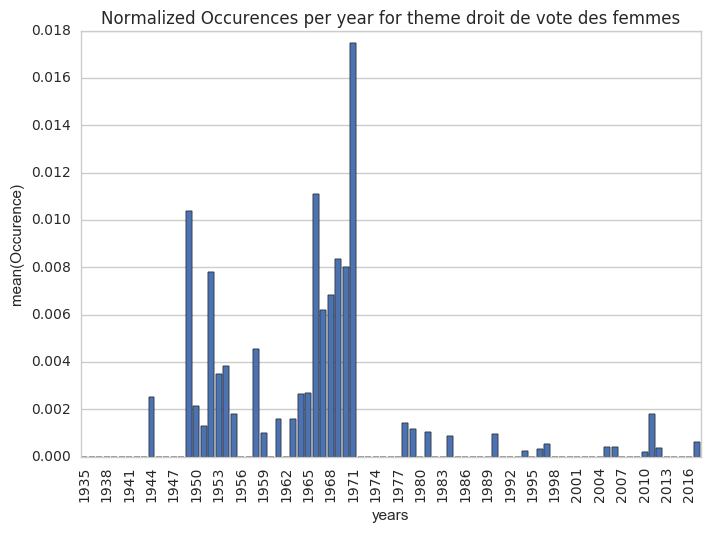

féminisme


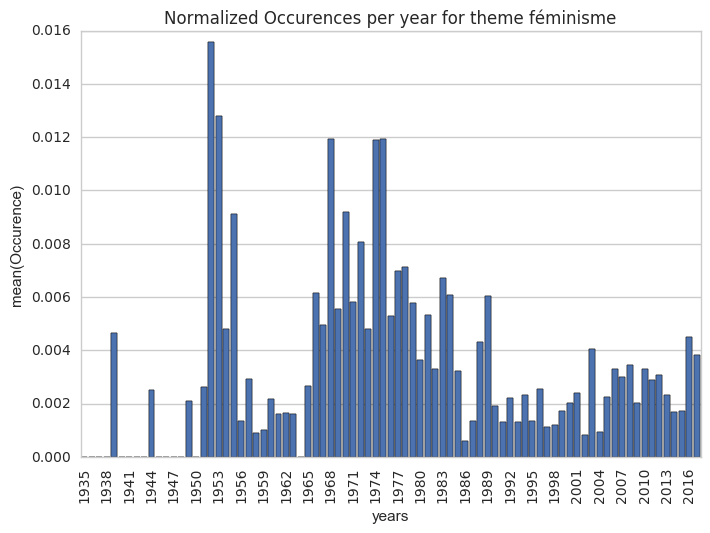

terrorisme


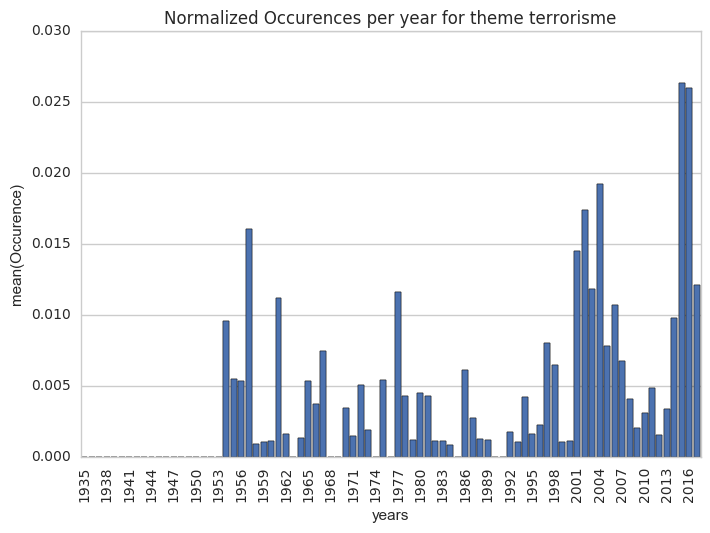

famille


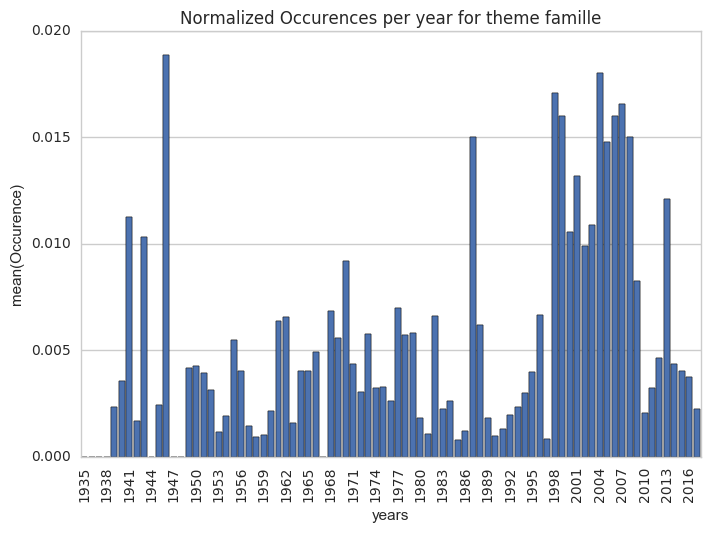

mariage


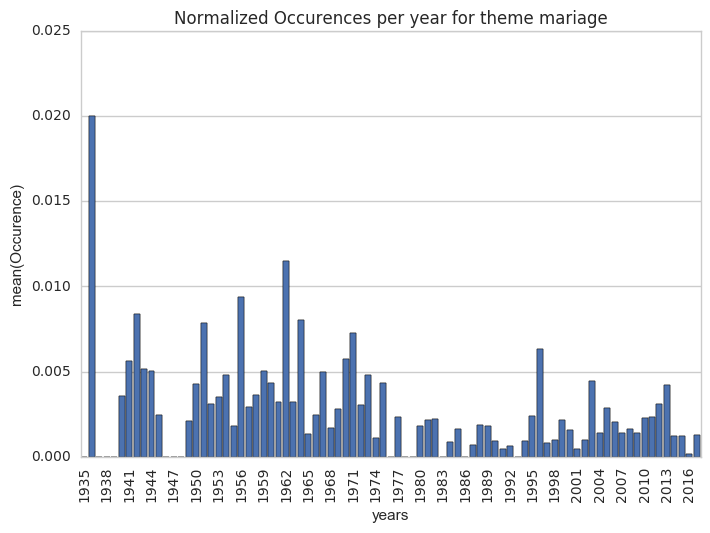

homosexualité


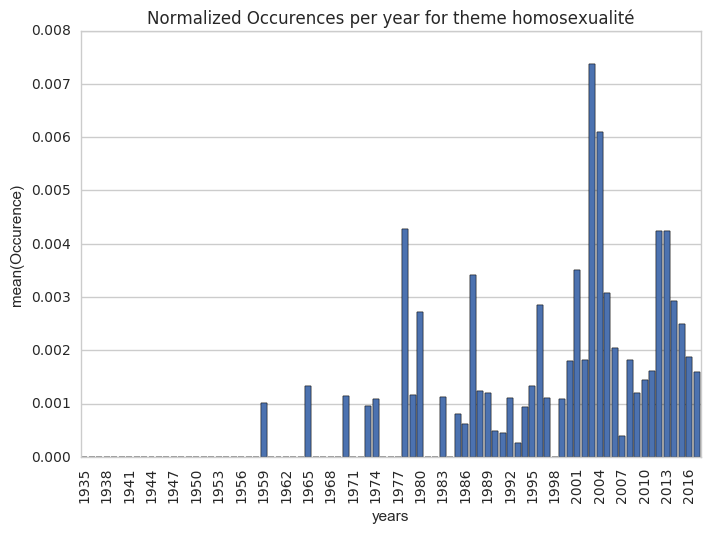

In [147]:

searchedWords = ['droit de vote des femmes','féminisme', 'terrorisme','famille','mariage','homosexualité']


beginyear, endyear = 1935,2017

for word in searchedWords: 
    results = nbOccurenceThemePerYearRange(df_themes,word,beginyear,endyear)
    coOccurences = coOccurenceThemePerYearRange(df_themes,word,beginyear,endyear)
    
    
    dfresults = pd.DataFrame((dict(years=range(beginyear,endyear+1), Occurence=results,CoOccurence=coOccurences)))
    dfresults.to_csv('storySina/'+word+'.csv', encoding='utf-8')
    fig, ax = plt.subplots() 
    sns.set_style("whitegrid")
    g = sns.barplot("years", "Occurence", data=dfresults)
    labels = ax.get_xticklabels() 
    for i,l in enumerate(labels):
        if(i%3 != 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
    plt.bar(range(len(results)), results, align='center')
    plt.title('Normalized Occurences per year for theme '+word)
    plt.show()


The seaborn library does not support the advanced hovering options that we needed. So we used instead the plotly library to include co-occurence in the hovering text. 
We then export the plotly plots to include them in our data story. <br>
Below only one plotly is shown, for illustation purpuses. Go ahead and hover over the bars to see appearing surprising things :) 

In [143]:
data = [go.Bar(
    x=dfresults.years,
    y=dfresults.Occurence,
    text=dfresults.CoOccurence,


    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
)]
layout = go.Layout(
    title='Normalized Occurences per year for theme '+word,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='text-hover-bar')